In [1]:
import os
# Find the latest version of spark 3.x  from https://downloads.apache.org/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,084 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,858 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu 

In [2]:
 # Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:
 # Read in real_estate_sales.csv data from the S3 Bucket realestateproj
from pyspark import SparkFiles
url ="https://realestateproj.s3.ap-southeast-2.amazonaws.com/real-estate-sales.csv"
spark.sparkContext.addFile(url)
df_real_estate_sales = spark.read.csv(SparkFiles.get("real-estate-sales.csv"), header=True, inferSchema=True)

# Show DataFrame
df_real_estate_sales.show(3)

+-------------+---------+-------------+-------+---------------+--------------+-----------+-----------+-------------+----------------+------------+----------------+-----------+--------------------+
|Serial Number|List Year|Date Recorded|   Town|        Address|Assessed Value|Sale Amount|Sales Ratio|Property Type|Residential Type|Non Use Code|Assessor Remarks|OPM remarks|            Location|
+-------------+---------+-------------+-------+---------------+--------------+-----------+-----------+-------------+----------------+------------+----------------+-----------+--------------------+
|      2020348|     2020|   09/13/2021|Ansonia|230 WAKELEE AVE|      150500.0|   325000.0|      0.463|   Commercial|            NULL|        NULL|            NULL|       NULL|                NULL|
|        20002|     2020|   10/02/2020|Ashford|390 TURNPIKE RD|      253000.0|   430000.0|     0.5883|  Residential|   Single Family|        NULL|            NULL|       NULL|                NULL|
|       210317|

In [4]:
# check the dataframe and drop any with null values
print("total rows in the original dataset:", df_real_estate_sales.count())
df_real_estate_sales_clean = df_real_estate_sales[["List Year", "Town","Assessed Value","Sale Amount","Sales Ratio",
                                                  "Property Type", "Non Use Code"]].dropna(how='any')
print("total non_null rows:", df_real_estate_sales_clean.count())
# rename the column names
columns_to_rename = {"List Year":"list_year", "Assessed Value":"assessed_value", "Sale Amount":"sale_amount", "Sales Ratio":"sales_ratio", "Property Type":"property_type", "Non Use Code":"non_use_code"}
for old_name, new_name in columns_to_rename.items():
  df_real_estate_sales_clean=df_real_estate_sales_clean.withColumnRenamed(old_name, new_name)
df_real_estate_sales_clean.show(3)

total rows in the original dataset: 1054159
total non_null rows: 197759
+---------+--------+--------------+-----------+-----------+-------------+------------------+
|list_year|    Town|assessed_value|sale_amount|sales_ratio|property_type|      non_use_code|
+---------+--------+--------------+-----------+-----------+-------------+------------------+
|     2020|  Berlin|      234200.0|   130000.0|     1.8015|  Residential|08 - Part Interest|
|     2020| Bristol|       88060.0|    91000.0|     0.9676|  Residential|  14 - Foreclosure|
|     2020|Cheshire|      144220.0|   204000.0|     0.7069|  Residential|        25 - Other|
+---------+--------+--------------+-----------+-----------+-------------+------------------+
only showing top 3 rows



In [5]:
# Import libraries to build and evaluate models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
%matplotlib inline


In [6]:
# Convert Spark DataFrame to Pandas DataFrame
df_real_estate_sales_pandas = df_real_estate_sales_clean.toPandas()
df_real_estate_sales_pandas = pd.get_dummies(df_real_estate_sales_pandas, dtype=int)

# Print the first few rows of the Pandas DataFrame
df_real_estate_sales_pandas.head(3)

,list_year,assessed_value,sale_amount,sales_ratio,Town_***Unknown***,Town_Andover,Town_Ansonia,Town_Ashford,Town_Avon,Town_Barkhamsted,...,non_use_code_21 - Personal Property Exchange,non_use_code_22 - Money and Personal Property,non_use_code_23 - Zoning,non_use_code_24 - Plottage,non_use_code_25 - Other,non_use_code_26 - Rehabilitation Deferred,non_use_code_27 - CRUMBLING FOUNDATION ASSESSMENT REDUCTION,non_use_code_28 - Use Assessment,non_use_code_29 - No Consideration,non_use_code_30 - Auction
0,2020,234200.0,130000.0,1.8015,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020,88060.0,91000.0,0.9676,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020,144220.0,204000.0,0.7069,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [7]:
# Selecting one year's data for efficient executions
modelling_df = pd.DataFrame(df_real_estate_sales_pandas.loc[df_real_estate_sales_pandas["list_year"]==2021,:])

In [8]:
# Make a copy of the DataFrame for further analyses
X = modelling_df.copy()
X.count()

list_year                                                      12561
assessed_value                                                 12561
sale_amount                                                    12561
sales_ratio                                                    12561
Town_***Unknown***                                             12561
                                                               ...  
non_use_code_26 - Rehabilitation Deferred                      12561
non_use_code_27 - CRUMBLING FOUNDATION ASSESSMENT REDUCTION    12561
non_use_code_28 - Use Assessment                               12561
non_use_code_29 - No Consideration                             12561
non_use_code_30 - Auction                                      12561
Length: 215, dtype: int64

In [10]:
# Define the target variable
y=X["sale_amount"].ravel()
y[:2]

array([985000.,  75000.])

In [14]:
# Define the features
X.drop("sale_amount", axis=1, inplace=True)
X.drop("list_year", axis=1, inplace=True)
X.head(2)

,assessed_value,sales_ratio,Town_***Unknown***,Town_Andover,Town_Ansonia,Town_Ashford,Town_Avon,Town_Barkhamsted,Town_Beacon Falls,Town_Berlin,...,non_use_code_21 - Personal Property Exchange,non_use_code_22 - Money and Personal Property,non_use_code_23 - Zoning,non_use_code_24 - Plottage,non_use_code_25 - Other,non_use_code_26 - Rehabilitation Deferred,non_use_code_27 - CRUMBLING FOUNDATION ASSESSMENT REDUCTION,non_use_code_28 - Use Assessment,non_use_code_29 - No Consideration,non_use_code_30 - Auction
9,335000.0,0.3401,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
12,200.0,0.0026,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_scaler = scaler.fit(X_train)

# Transform the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
# Fitting the Random Forest Model
# Create a random forest model
rf_model = RandomForestRegressor(n_estimators=500, random_state=78)

In [17]:
# Fitting the model
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=500, random_state=78)

In [18]:
# Making predictions using the testing data
y_pred = rf_model.predict(X_test_scaled)

In [22]:
#Evaluate the model
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)

print(f"Root Mean Squre Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Root Mean Squre Error (RMSE): 373260.0902418174
R-squared (R2): 0.9468606929008136


In [23]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
important_features = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
important_features[:20]

[(0.5940389597033026, 'assessed_value'),
 (0.28336930661469456, 'sales_ratio'),
 (0.03884935244141868, 'Town_Stamford'),
 (0.0362375182659268, 'property_type_Vacant Land'),
 (0.011091125347048432, 'Town_Danbury'),
 (0.007688051970553405, 'property_type_Commercial'),
 (0.005561160116574793, 'property_type_Industrial'),
 (0.005517495256488435, 'non_use_code_25 - Other'),
 (0.0036446874113441373, 'property_type_Apartments'),
 (0.002951261812692707, 'Town_Newington'),
 (0.0016587141583278518, 'non_use_code_03 - Inter Corporation'),
 (0.0015618787851019228, 'Town_Windsor'),
 (0.001103815724157341, 'Town_Waterbury'),
 (0.0008449329187327376, 'Town_Fairfield'),
 (0.0006399235240486557, 'Town_Westport'),
 (0.0005339454542810733, 'Town_Orange'),
 (0.000440561691845612, 'non_use_code_07 - Change in Property'),
 (0.0003728967062119795, 'Town_Suffield'),
 (0.0003599586828522451, 'Town_North Haven'),
 (0.0003587920283810523, 'property_type_Residential')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

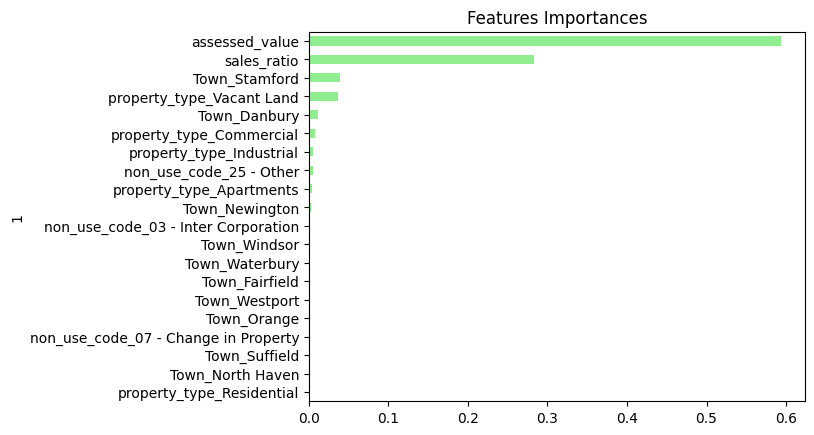

In [28]:
# Visualize the features by importance
importances_df = pd.DataFrame(important_features[:20])
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

**Optimise the model**

In [38]:
# winsorize the continuous features
from scipy.stats.mstats import winsorize
modelling_df["assessed_value_w"]= winsorize(modelling_df["assessed_value"], limits=(0.05, 0.95))
modelling_df["sale_amount_w"]= winsorize(modelling_df["sale_amount"], limits=(0.05, 0.95))
modelling_df["sales_ratio_w"]= winsorize(modelling_df["sales_ratio"], limits=(0.05, 0.95))
modelling_df.head(3)

,list_year,assessed_value,sale_amount,sales_ratio,Town_***Unknown***,Town_Andover,Town_Ansonia,Town_Ashford,Town_Avon,Town_Barkhamsted,...,non_use_code_24 - Plottage,non_use_code_25 - Other,non_use_code_26 - Rehabilitation Deferred,non_use_code_27 - CRUMBLING FOUNDATION ASSESSMENT REDUCTION,non_use_code_28 - Use Assessment,non_use_code_29 - No Consideration,non_use_code_30 - Auction,assessed_value_w,sale_amount_w,sales_ratio_w
9,2021,335000.0,985000.0,0.3401,0,0,0,0,0,0,...,0,0,0,0,1,0,0,9710.0,25344.0,0.0525
12,2021,200.0,75000.0,0.0026,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9710.0,25344.0,0.0525
14,2021,49000.0,100000.0,0.4900,0,0,0,0,0,0,...,0,1,0,0,0,0,0,9710.0,25344.0,0.0525


In [39]:
# Re_split our preprocessed data into our features and target arrays
y = modelling_df["sale_amount_w"]
# # keep the most important features including the winsorised columns
# X = modelling_df[["assessed_value_w", "Town_Stamford", "property_type_Vacant Land", "Town_Danbury",
#                  "property_type_Commercial", "property_type_Industrial", "non_use_code_25 - Other", "property_type_Apartments", "Town_Newington"
#                  ]]
# Define the features
columns = ["sale_amount", "assessed_value", "sales_ratio","list_year", "sale_amount_w"]
X = modelling_df.drop(columns, axis=1)
X.head(2)

,Town_***Unknown***,Town_Andover,Town_Ansonia,Town_Ashford,Town_Avon,Town_Barkhamsted,Town_Beacon Falls,Town_Berlin,Town_Bethany,Town_Bethel,...,non_use_code_23 - Zoning,non_use_code_24 - Plottage,non_use_code_25 - Other,non_use_code_26 - Rehabilitation Deferred,non_use_code_27 - CRUMBLING FOUNDATION ASSESSMENT REDUCTION,non_use_code_28 - Use Assessment,non_use_code_29 - No Consideration,non_use_code_30 - Auction,assessed_value_w,sales_ratio_w
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,9710.0,0.0525
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9710.0,0.0525


In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_scaler = scaler.fit(X_train)

# Transform the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the neural network model
model = Sequential()

# Add input layer and first hidden layer
model.add(Dense(units=213, input_dim=X_train_scaled.shape[1], activation='relu'))

# Add a second hidden layer
model.add(Dense(units=64, activation='relu'))

# Add the output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
314/314 [==============================] - 2s 4ms/step - loss: 575149440.0000 - mae: 23923.9062
Epoch 2/100
314/314 [==============================] - 1s 4ms/step - loss: 121271696.0000 - mae: 9187.1064
Epoch 3/100
314/314 [==============================] - 1s 2ms/step - loss: 4487526.5000 - mae: 1018.3718
Epoch 4/100
314/314 [==============================] - 1s 2ms/step - loss: 2699786.2500 - mae: 524.8979
Epoch 5/100
314/314 [==============================] - 1s 2ms/step - loss: 2232620.7500 - mae: 422.1975
Epoch 6/100
314/314 [==============================] - 1s 2ms/step - loss: 1976913.3750 - mae: 375.7764
Epoch 7/100
314/314 [==============================] - 1s 2ms/step - loss: 1794474.2500 - mae: 339.9232
Epoch 8/100
314/314 [==============================] - 1s 2ms/step - loss: 1654017.6250 - mae: 308.6532
Epoch 9/100
314/314 [==============================] - 1s 2ms/step - loss: 1540746.2500 - mae: 280.7254
Epoch 10/100
314/314 [==============================] - 

In [42]:
# Evaluate the model on the test data
y_pred = model.predict(X_test_scaled)
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)
r2 = r2_score(y_test, y_pred)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")
print(f"R-squared: {r2}")

79/79 [==============================] - 0s 2ms/step - loss: 389032.0938 - mae: 110.2566
Test Loss: 389032.09375, Test MAE: 110.2565689086914
R-squared: 0.0


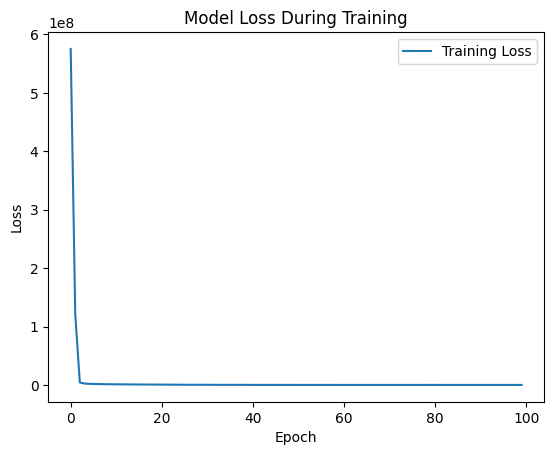

In [43]:
# Plot the training history
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()